# Pattern Matching on Sensor Data

This example explores the process of conducting pattern matching on time series manufacturing data using a similarity search in KDB.AI. 

Our goal is to identify and retrieve historical time series that exhibit specific patterns. This matching capability is instrumental in a wide array of manufacturing scenarios, including quality control, process optimization, and predictive maintenance. For instance, imagine a scenario where we have time series data representing machinery performance, and we need to pinpoint instances of unusual behaviour, such as spikes, drops, or recurring trends.

We will guide you through a straightforward approach that leverages the raw time series data directly, without the need for complex modelling or domain-specific expertise. This approach is particularly attractive because it doesn't require additional resources for model creation. The sample will demonstrate that this simplistic method can yield satisfactory results. 

## Aim

This tutorial will walk through the process of storing time series data in a vector database, using windowing and normalization to generate simple time series vector embeddings. We will use KDB.AI's vector database to find historical patterns that match an input query pattern. We will cover the following topics:

- How to create vector embeddings for time series data
- How to store those embeddings in KDB.AI
- Query KDB.AI's vector database to find historical patterns

## Install Dependencies

In [1]:
!pip install matplotlib kdbai_client -q

## 1. Download Data

### Dataset Overview
The dataset that will be used for this example is the [Water Pump Sensor Dataset](https://www.kaggle.com/datasets/nphantawee/pump-sensor-data) available on Kaggle. The datatset consist of a sensor.csv file which has raw values from 52 sensors from a town water pump.

### Download Data

You can either manually download the zip folder from [Kaggle (39MB)](https://www.kaggle.com/datasets/nphantawee/pump-sensor-data) or alternatively you can use the [Kaggle API](https://www.kaggle.com/docs/api). You will need to install the kaggle package and get an API token to do the latter approach.

Here we do the first option, downloading locally and then loading to the environment. Extract this folder using zipfile or preferred equivalent to access the sensor.csv file. Adjust the filename and path to match yours if necessary.

In [2]:
# Extract Zip file after uploading images (archive.zip folder from Kaggle)
from zipfile import ZipFile


def extractZip(file_name):
    with ZipFile(file_name, "r") as zip:
        zip.extractall()
        print("Done")


extractZip("archive.zip")

Done


You should now have a sensor.csv file.

### Load Data & Cleanup

Let's do some preparation on the dataset to clean it up. We will remove duplicates, drop  irrelevant columns and handle missing data.

In [3]:
import pandas as pd

df = pd.read_csv("sensor.csv")
df = df.drop_duplicates()  # Drop duplicates
df = df.drop(
    ["Unnamed: 0", "sensor_15", "sensor_50"], axis=1
)  # Remove columns that are unnecessary/bad data
df["timestamp"] = pd.to_datetime(
    df["timestamp"]
)  # convert timestamp to datetime format
df = df.dropna()  # Removes rows with any NaN values
df

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,...,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,231.1921,NORMAL
220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,...,29.947920,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,231.1921,NORMAL
220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,...,30.208330,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,232.0602,NORMAL
220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,...,30.208332,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,234.0856,NORMAL


This dataset has 52 sensor columns - for the purposes of this example we will only select the first one `sensor_00` for simplicity.

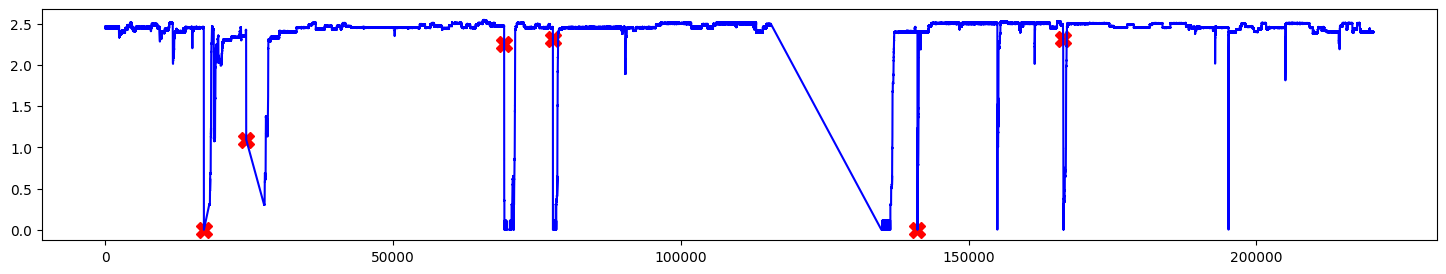

In [4]:
import matplotlib.pyplot as plot

# Extract the readings from the BROKEN state of the pump
broken = df[df["machine_status"] == "BROKEN"]
# Extract the names of the numerical columns
df = df[["timestamp", "sensor_00"]]

# Plot time series for each sensor with BROKEN state marked with X in red color
plot.figure(figsize=(18, 3))
plot.plot(broken["sensor_00"], linestyle="none", marker="X", color="red", markersize=12)
plot.plot(df["sensor_00"], color="blue")
plot.show()

We can see above that over time the sensor values stay generally around 2.5 with a few noisy dropoff spikes. We have plotted the column `machine_status=BROKEN` in red here which corresponds with a lot of these spikes indicating the reason for the dropoffs.

## 2. Create Embedding

Next, let's create embeddings for these values. To do this we use a combination of windowing and normalizing the data. We have chosen a simple approach that leverages the raw time series data directly, without the need for complex modelling or domain-specific expertise.

### Windowing

The code below divides the original time series data into overlapping windows, with each window containing a specified number of rows and a step size determining how they are shifted along the timeline. It also extracts a timestamp from each window as we will want to store this as metadata.

In [5]:
# Set the window size (number of rows in each window)
window_size = 24
step_size = 10

# Initialize empty lists to store results
start_times = []
end_times = []
sensor_values = []

# Iterate through the DataFrame with the specified step size
for i in range(0, len(df) - window_size + 1, step_size):
    window = df.iloc[i : i + window_size]
    start_time = window["timestamp"].iloc[0]
    end_time = window["timestamp"].iloc[-1]
    values_in_window = window["sensor_00"].tolist()
    start_times.append(start_time)
    end_times.append(end_time)
    sensor_values.append(values_in_window)

# Create a new DataFrame from the collected data
result_data = {"startTime": start_times, "endTime": end_times, "vectors": sensor_values}
result_df = pd.DataFrame(result_data)


# Print the resulting DataFrame
print(result_df)

                startTime             endTime  \
0     2018-04-01 00:00:00 2018-04-01 00:23:00   
1     2018-04-01 00:10:00 2018-04-01 00:33:00   
2     2018-04-01 00:20:00 2018-04-01 00:43:00   
3     2018-04-01 00:30:00 2018-04-01 00:53:00   
4     2018-04-01 00:40:00 2018-04-01 01:03:00   
...                   ...                 ...   
19575 2018-08-31 22:55:00 2018-08-31 23:18:00   
19576 2018-08-31 23:05:00 2018-08-31 23:28:00   
19577 2018-08-31 23:15:00 2018-08-31 23:38:00   
19578 2018-08-31 23:25:00 2018-08-31 23:48:00   
19579 2018-08-31 23:35:00 2018-08-31 23:58:00   

                                                 vectors  
0      [2.465394, 2.465394, 2.444734, 2.460474, 2.445...  
1      [2.46441, 2.444734, 2.460474, 2.448669, 2.4535...  
2      [2.445718, 2.460474, 2.448669, 2.453588, 2.453...  
3      [2.463426, 2.448669, 2.453588, 2.455556, 2.449...  
4      [2.449653, 2.453588, 2.453588, 2.448669, 2.460...  
...                                                  ... 

### Normalization & Scaling

Next, we perform manual normalization of sensor values within each time-based window. This ensures that the sensor values are scaled uniformly between 0 and 1 which is better for further analysis. Additionally, the DataFrame's index is reset to maintain a clean and continuous row numbering.


In [6]:
# Normalize the sensorValue column manually
max_value = result_df["vectors"].apply(max)
min_value = result_df["vectors"].apply(min)
result_df["vectors"] = result_df["vectors"].apply(
    lambda x: [
        (v - min_val) / (max_val - min_val)
        for v, max_val, min_val in zip(x, max_value, min_value)
    ]
)

# Print the resulting DataFrame
print(result_df)

# reset index
result_df = result_df.reset_index(drop=True)

                startTime             endTime  \
0     2018-04-01 00:00:00 2018-04-01 00:23:00   
1     2018-04-01 00:10:00 2018-04-01 00:33:00   
2     2018-04-01 00:20:00 2018-04-01 00:43:00   
3     2018-04-01 00:30:00 2018-04-01 00:53:00   
4     2018-04-01 00:40:00 2018-04-01 01:03:00   
...                   ...                 ...   
19575 2018-08-31 22:55:00 2018-08-31 23:18:00   
19576 2018-08-31 23:05:00 2018-08-31 23:28:00   
19577 2018-08-31 23:15:00 2018-08-31 23:38:00   
19578 2018-08-31 23:25:00 2018-08-31 23:48:00   
19579 2018-08-31 23:35:00 2018-08-31 23:58:00   

                                                 vectors  
0      [1.0, 1.050010164667609, 0.0, 0.71426496926279...  
1      [0.9523717328170437, 0.0, 0.7999593413295418, ...  
2      [0.04762826718295637, 0.7999593413295418, 0.19...  
3      [0.9047434656340873, 0.19998983533239675, 0.44...  
4      [0.23809293320426628, 0.44998983533237985, 0.4...  
...                                                  ... 

## 3. Store Embeddings in KDB.AI 

### Connect to KDB.AI Session

To use KDB.AI, you will need two session details - a URL endpoint and an API key. To get these you can sign up for free [here](https://trykdb.kx.com/kdbai/signup).

You can connect to a KDB.AI session using `kdbai.Session`. Enter the session URL endpoint and API key details from your KDB.AI Cloud portal below.

In [ ]:
import kdbai_client as kdbai
from getpass import getpass

KDBAI_ENDPOINT = input('KDB.AI endpoint: ')
KDBAI_API_KEY = getpass('KDB.AI API key: ')
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

### Define Schema

The next step is to define a schema for our KDB.AI table where we will store our embeddings. Our table will have three colums: startTime, endTime, vectors.

In [8]:
sensor_schema = {
    "columns": [
        {
            "name": "startTime",
            "pytype": "datetime64[ns]",
        },
        {
            "name": "endTime",
            "pytype": "datetime64[ns]",
        },
        {
            "name": "vectors",
            "vectorIndex": {"dims": window_size, "metric": "L2", "type": "hnsw"},
        },
    ]
}

### Create and Save Table

In [15]:
table = session.create_table("sensors", sensor_schema)

### Add Embeddings to Table

When adding larger amounts of data, you may need insert data into an index in chunks. It is a good idea to first get an idea of how large the dataset to insert is.

In [16]:
result_df.memory_usage(deep=True).sum() / (1024**2)  # Convert bytes to MB

4.7803955078125

This is fairly small <10MB due so we are good to add all in one go.

In [19]:
table.insert(result_df)

True

## 4. Query 

Now that all the embeddings of the images are in KDB.AI's database, it's time to demonstrate KDB.AI's fast query capabilities.

We can use `query` to query data from the table.


In [20]:
table.query()

,startTime,endTime,vectors
0,2018-04-01 00:00:00,2018-04-01 00:23:00,"[1.0, 1.050010164667609, 0.0, 0.71426496926279..."
1,2018-04-01 00:10:00,2018-04-01 00:33:00,"[0.9523717328170437, 0.0, 0.7999593413295418, ..."
2,2018-04-01 00:20:00,2018-04-01 00:43:00,"[0.04762826718295637, 0.7999593413295418, 0.19..."
3,2018-04-01 00:30:00,2018-04-01 00:53:00,"[0.9047434656340873, 0.19998983533239675, 0.44..."
4,2018-04-01 00:40:00,2018-04-01 01:03:00,"[0.23809293320426628, 0.44998983533237985, 0.4..."
...,...,...,...
19575,2018-08-31 22:55:00,2018-08-31 23:18:00,"[-2.0475798644724192, -2.2500000000000058, -2...."
19576,2018-08-31 23:05:00,2018-08-31 23:28:00,"[-1.9523717328170436, -2.4499898353323797, -2...."
19577,2018-08-31 23:15:00,2018-08-31 23:38:00,"[-2.0475798644724192, -2.2500000000000058, -1...."
19578,2018-08-31 23:25:00,2018-08-31 23:48:00,"[-1.857115198451131, -2.4499898353323797, -1.9..."


## 5. Pattern Matching

Now our data is loaded successfully, we can perform pattern matching on our historical sensor data using KDB.AI `search`. 

### Example Pattern to Query 

The first step is to select a pattern that will be used to query. We chose by selecting a start time, then filtering to get the vector's values for that record and store in a variable called `query_vector`. Any pattern could be selected here.

The resulting query pattern is also displayed as a line plot for visual inspection and analysis.

(array([17622.54166667, 17622.54513889, 17622.54861111, 17622.55208333,
        17622.55555556]),
 [Text(17622.541666666668, 0, '01 13:00'),
  Text(17622.54513888889, 0, '01 13:05'),
  Text(17622.54861111111, 0, '01 13:10'),
  Text(17622.552083333332, 0, '01 13:15'),
  Text(17622.555555555555, 0, '01 13:20')])

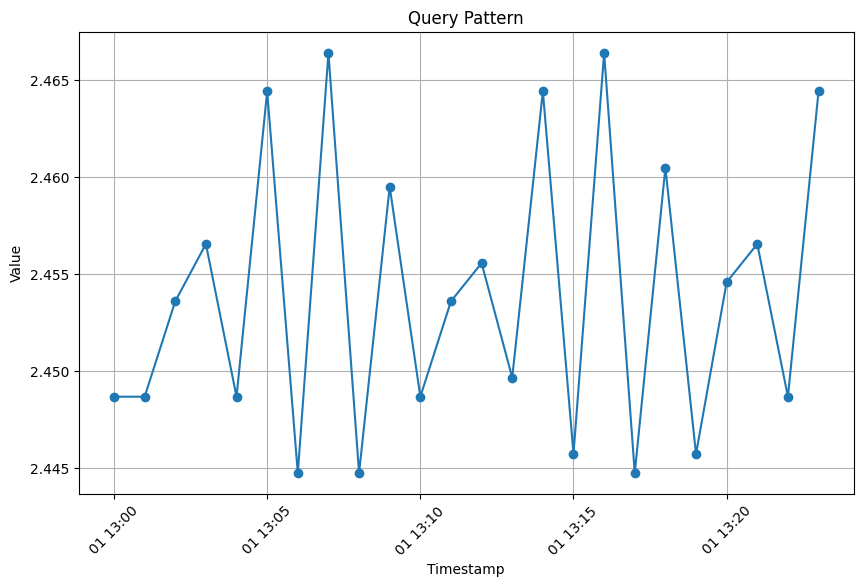

In [49]:
## Select historical pattern
random_start_time = pd.to_datetime("2018-04-01 13:00:00")

# Filter result_df based on the specific startTime
query_vector = result_df[result_df["startTime"] == random_start_time][
    "vectors"
].values.tolist()

## Select historical pattern
df_query_times = result_df[result_df["startTime"] == random_start_time]
query_df = df[(df["timestamp"] >= df_query_times.iloc[0]["startTime"]) & (df["timestamp"] <= df_query_times.iloc[0]["endTime"])]

# Create a line plot
plot.figure(figsize=(10, 6))
plot.plot(query_df["timestamp"], query_df["sensor_00"], marker="o", linestyle="-")
plot.xlabel("Timestamp")
plot.ylabel("Value")
plot.title("Query Pattern")
plot.grid(True)
plot.xticks(rotation=45)  # Rotate x-axis labels for readability

### Search Based on Example Pattern

Using the embeddings we extracted above in `query_vector` for a random time series pattern, we can search to get the five nearest neighbors using KDB.AI.

In a real life scenario, the example pattern could be some real time data as selected by a machine operator or engineer to pinpoint instances of unusual behavior such as spikes, drops, or recurring trends.

In [51]:
result = table.search(query_vector, n=5)
result[0]

,startTime,endTime,vectors,__nn_distance
0,2018-04-01 13:00:00,2018-04-01 13:23:00,"[0.1904646660213099, 0.19998983533239675, 0.44...",0.000000
1,2018-06-19 16:00:00,2018-06-19 16:23:00,"[0.1904646660213099, 0.19998983533239675, 0.69...",0.286267
2,2018-04-02 03:00:00,2018-04-02 03:23:00,"[0.33330106485964195, 0.34996950599716203, 0.3...",0.297918
3,2018-04-02 06:20:00,2018-04-02 06:43:00,"[0.7142787996127774, 0.19998983533239675, 0.55...",0.312028
4,2018-04-06 05:30:00,2018-04-06 05:53:00,"[0.523814133591489, 0.30001016466761454, 0.550...",0.320408


The results returned from `table.search` show the closest matches along with value of nearest neighbor distances `nn_distance`. This is helpful to keep in for visulization purposes so we can compare how similar it is to the matches found.

The first result is an exact match as the example pattern we chose was from the existing dataset. 

### Visualize Results

Let's plot these neighbors overlayed with each other on a chart. This is useful for visualizing and analyzing time series data patterns and their relationships.

The code snippet below performs a time-based pattern matching and visualization process, calculating time differences, assiging labels to patterns, and then plotting these patterns with legends to distinguish and display them.

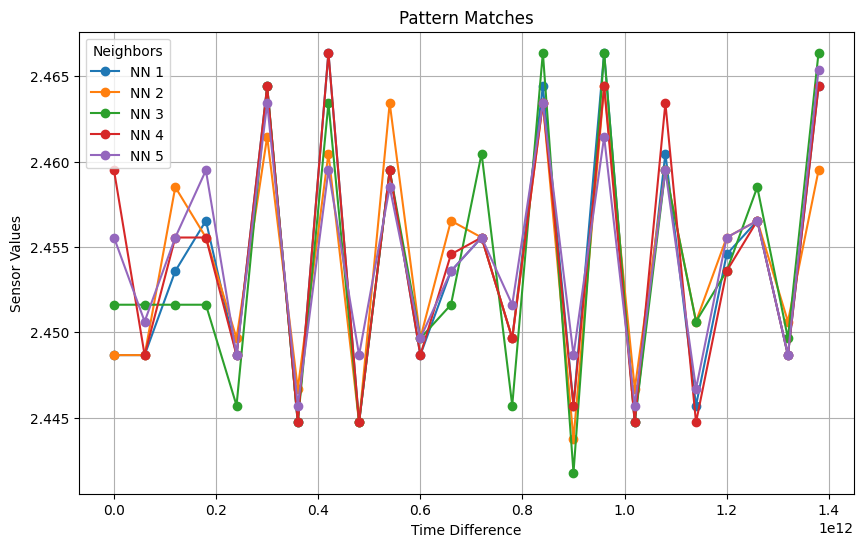

In [52]:
df1 = df
df2 = result[0]

# Create a list to store the results
result_list = []
# Initialize label counter
label_counter = 1

# Iterate through the rows of df2 to filter df1 and calculate time differences
for index, row in df2.iterrows():
    mask = (df1["timestamp"] >= row["startTime"]) & (df1["timestamp"] <= row["endTime"])
    filtered_df = df1[mask].copy()  # Create a copy of the filtered DataFrame
    filtered_df["time_difference"] = filtered_df["timestamp"] - row["startTime"]
    filtered_df["pattern"] = label_counter
    label_counter += 1  # Increment the label counter
    result_list.append(filtered_df)

# Concatenate the results into a new DataFrame
result_df2 = pd.concat(result_list)

# Group by 'label_counter' and plot each group separately with a legend
groups = result_df2.groupby("pattern")
fig, ax = plot.subplots(figsize=(10, 6))

for name, group in groups:
    ax.plot(
        group["time_difference"], group["sensor_00"], marker="o", label=f"NN {name}"
    )

ax.set_xlabel("Time Difference")
ax.set_ylabel("Sensor Values")
ax.legend(title="Neighbors")
plot.title("Pattern Matches")
plot.grid(True)
plot.show()

Remember the blue line `NN 1` is our query vector, we can see the overall pattern matches closely with the other matches found. 

Let's try another input query and see what result we get.

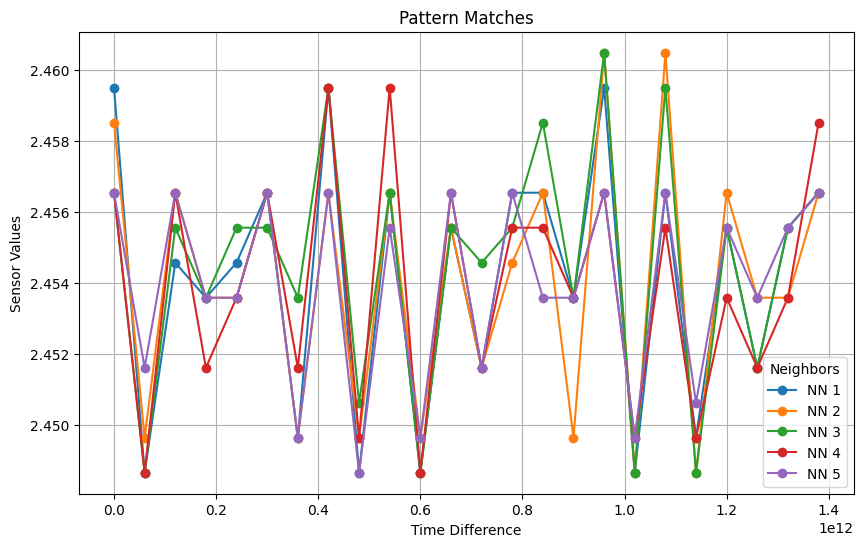

In [53]:
## Select historical pattern
random_start_time = pd.to_datetime("2018-04-12 21:10:00")

# Filter result_df based on the specific startTime
query_vector = result_df[result_df["startTime"] == random_start_time][
    "vectors"
].values.tolist()

## Select historical pattern
df_query_times = result_df[result_df["startTime"] == random_start_time]
query_df = df[(df["timestamp"] >= df_query_times.iloc[0]["startTime"]) & (df["timestamp"] <= df_query_times.iloc[0]["endTime"])]

result = table.search(query_vector, n=5)

df1 = df
df2 = result[0]

# Create a list to store the results
result_list = []
# Initialize label counter
label_counter = 1

# Iterate through the rows of df2 to filter df1 and calculate time differences
for index, row in df2.iterrows():
    mask = (df1["timestamp"] >= row["startTime"]) & (df1["timestamp"] <= row["endTime"])
    filtered_df = df1[mask].copy()  # Create a copy of the filtered DataFrame
    filtered_df["time_difference"] = filtered_df["timestamp"] - row["startTime"]
    filtered_df["pattern"] = label_counter
    label_counter += 1  # Increment the label counter
    result_list.append(filtered_df)

# Concatenate the results into a new DataFrame
result_df2 = pd.concat(result_list)

# Group by 'label_counter' and plot each group separately with a legend
groups = result_df2.groupby("pattern")
fig, ax = plot.subplots(figsize=(10, 6))

for name, group in groups:
    ax.plot(
        group["time_difference"], group["sensor_00"], marker="o", label=f"NN {name}"
    )

ax.set_xlabel("Time Difference")
ax.set_ylabel("Sensor Values")
ax.legend(title="Neighbors")
plot.title("Pattern Matches")
plot.grid(True)
plot.show()

This is also a pretty close match! 

We can see even with a simplistic method for embedding our time series data we can yield satisfactory results.